In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

import inspect

fontP = FontProperties()
fontP.set_size('small')

Using TensorFlow backend.


In [2]:
#Check Versions
print(tf.__version__)  #1.15.0
print(keras.__version__)  #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

We will now parametrize our network by giving it $\mu$ and $\sigma$ values in addition to $X_i\sim\mathcal{N}(\mu, \sigma)$.

First we uniformly sample $\mu$ and $\sigma$ values in some range

In [3]:
mu_min = -2
mu_max = 2

sigma_min = 0.5
sigma_max = 4.5

We then sample from normal distributions with these $\mu$ and $\sigma$ values.

Please note that the samples in X0 are not paired with $\mu=0, \sigma = 1$ as this would make the task trivial. 

Instead it is paired with the $\mu, \sigma$ values uniformly sampled in the specified range [$\mu_{min}, \mu_{max}$] and [$\sigma_{min}, \sigma_{max}$].

For every value of $\mu$ in mu_values and every value of $\sigma$ in sigma_values, the network sees one event drawn from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and it learns to classify them. 

I.e. we have one network that's parametrized by $\mu$ and $\sigma$ that classifies between events from $\mathcal{N}(0,1)$ and $\mathcal{N}(\mu,\sigma)$, and a trained network will give us the likelihood ratio to reweight from one to another. 

## Build and Train DCTR model

In [4]:
# Either load or train DCTR

def get_dctr(load=False, n_data_points=10**7):
    if load:
        json_file = open('2d_gaussian_dctr_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        dctr_model = keras.models.model_from_json(loaded_model_json)
        # load weights into new model
        dctr_model.load_weights("2d_gaussian_dctr_model.h5")
        print("Loaded model from disk")
    else:
        # Generate training & validation data
        mu_values = np.random.uniform(mu_min, mu_max, n_data_points)
        sigma_values = np.random.uniform(sigma_min, sigma_max, n_data_points)

        X0 = [(np.random.normal(0, 1), mu_values[i], sigma_values[i])
              for i in range(n_data_points)]  # Note the zero in normal(0, 1)
        X1 = [(np.random.normal(mu_values[i], sigma_values[i]), mu_values[i],
               sigma_values[i]) for i in range(n_data_points)]

        Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
        Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

        X = np.concatenate((X0, X1))
        Y = np.concatenate((Y0, Y1))

        X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                            Y,
                                                            test_size=0.5)

        # Build Model
        inputs = Input((3, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(2, activation='softmax')(hidden_layer_3)

        dctr_model = Model(inputs=inputs, outputs=outputs)
        dctr_model.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])

        # Train Model
        earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
        dctr_model.fit(X_train,
                       Y_train,
                       epochs=200,
                       batch_size=10000,
                       validation_data=(X_test, Y_test),
                       callbacks=[earlystopping])

    return dctr_model

### Loading Model

In [5]:
dctr_model = get_dctr(load=True)









Loaded model from disk


## Defining reweighting functions

For a fully trained DCTR $f(x, \theta)$, the reweighting function is: $w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$.

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

The expression for the analytical reweighting function is : $w(x_T, \mu, \sigma) = \frac{\sigma_0}{\sigma}\exp{(-((\frac{x_T-\mu}{\sigma})^2-(\frac{x_T-\mu_0}{\sigma_0})^2)/2)}$.

In [6]:
theta0_param = (0, 1)


# from NN (DCTR)
def reweight(events, param):

    # creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=(events.shape[0], 2)) * param
    # combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)
    f = dctr_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights


# from analytical formula for normal distributions
def analytical_reweight(events, param, param0=theta0_param):
    weights = (param0[1] / param[1]) * K.exp(-0.5 * (
        ((events - param[0]) / param[1])**2 -
        ((events - param0[0]) / param0[1])**2))
    return weights

## Validate DCTR for any $\mu$ and $\sigma$

## Validate for Truth Level

In [7]:
mu1 = 1.5
sigma1 = 1.5
assert mu1 >= mu_min and mu1 <= mu_max  # choose mu1 in valid range
assert sigma1 >= sigma_min and sigma1 <= sigma_max  # choose mu1 in valid range
X0_val_T = np.random.normal(0, 1, 10**6)
X1_val_T = np.random.normal(mu1, sigma1, 10**6)

In [8]:
weights = reweight(
    K.expand_dims(tf.convert_to_tensor(X0_val_T, dtype=tf.float32)),
    np.array([mu1, sigma1]))
analytical_weights = analytical_reweight(X0_val_T, np.array([mu1, sigma1]))
weights = K.eval(weights)
analytical_weights = K.eval(analytical_weights)

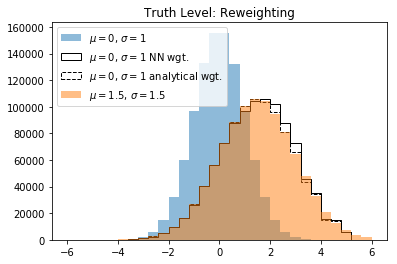

In [9]:
bins = np.linspace(-6, 6, 31)
plt.hist(X0_val_T, bins=bins, alpha=0.5, label=r'$\mu=0$, $\sigma=1$')
plt.hist(X0_val_T,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ NN wgt.',
         weights=weights,
         histtype='step',
         color='k')
plt.hist(X0_val_T,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ analytical wgt.',
         weights=analytical_weights,
         histtype='step',
         linestyle='--',
         color='k')
plt.hist(X1_val_T,
         bins=bins,
         alpha=0.5,
         label=r'$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
plt.legend()
plt.title("Truth Level: Reweighting")
plt.show()

## Validate for Detector Level

In [10]:
# Generate detector level by smearing truth

epsilon_val = 0.5  #Smearing width

X0_val_D = np.array([(x + np.random.normal(0, epsilon_val))
                     for x in X0_val_T])  #Detector smearing
X1_val_D = np.array([(x + np.random.normal(0, epsilon_val))
                     for x in X1_val_T])  #Detector smearing

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


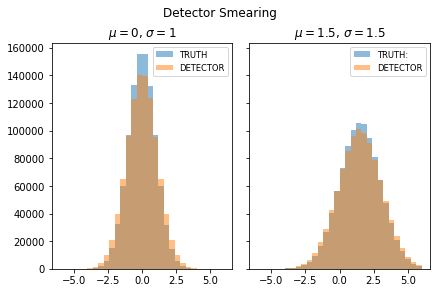

In [11]:
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Detector Smearing')
axs[0].set_title('$\mu=0$, $\sigma=1$')
axs[0].hist(X0_val_T, bins=bins, alpha=0.5, label='TRUTH')
axs[0].hist(X0_val_D, bins=bins, alpha=0.5, label='DETECTOR')
axs[0].legend(prop=fontP)
axs[1].set_title('$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
axs[1].hist(X1_val_T, bins=bins, alpha=0.5, label='TRUTH:')
axs[1].hist(X1_val_D, bins=bins, alpha=0.5, label='DETECTOR')
axs[1].legend(prop=fontP)
fig.show()

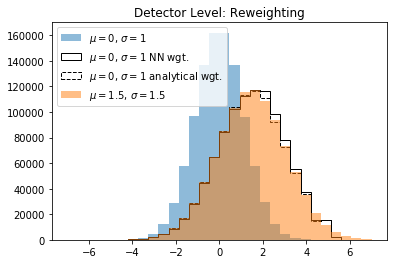

In [12]:
bins = np.linspace(-7, 7, 31)
plt.hist(X0_val_D, bins=bins, alpha=0.5, label=r'$\mu=0$, $\sigma=1$')
plt.hist(X0_val_D,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ NN wgt.',
         weights=weights,
         histtype='step',
         color='k')
plt.hist(X0_val_D,
         bins=bins,
         label=r'$\mu=0$, $\sigma=1$ analytical wgt.',
         weights=analytical_weights,
         histtype='step',
         linestyle='--',
         color='k')
plt.hist(X1_val_D,
         bins=bins,
         alpha=0.5,
         label=r'$\mu={}$, $\sigma={}$'.format(mu1, sigma1))
plt.legend()
plt.title("Detector Level: Reweighting")
#plt.savefig("Detector Level: Reweighting.png")
plt.show()

# Saving Model

In [13]:
'''
model_json = dctr_model.to_json()
with open("2d_gaussian_dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dctr_model.save_weights("2d_gaussian_dctr_model.h5")
print("Saved model to disk")
'''

'\nmodel_json = dctr_model.to_json()\nwith open("2d_gaussian_dctr_model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\ndctr_model.save_weights("2d_gaussian_dctr_model.h5")\nprint("Saved model to disk")\n'

# Alternative Fit

## Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

To apply detector effects, each event $x_{T,i}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,\epsilon)$,where $\epsilon$ represents the smearing. Thus: $x_{D,i} = x_{T,i} + Z_{i}$

In [14]:
N = 10**6
#param = (mu, sigma)
theta0_param = (
    0, 1
)  #this is the simulation ... N.B. this notation is reversed from above!
theta1_param = (1, 1.5)  #this is the data (the target)

epsilon = theta0_param[1] / 2  #Smearing width

theta0_T = np.random.normal(theta0_param[0], theta0_param[1], N)
theta0_D = np.array([(x + np.random.normal(0, epsilon))
                     for x in theta0_T])  #Detector smearing
theta0 = np.stack([theta0_T, theta0_D], axis=1)

theta1_T = np.random.normal(theta1_param[0], theta1_param[1], N)
theta1_D = np.array([(x + np.random.normal(0, epsilon))
                     for x in theta1_T])  #Detector smearing
theta1 = np.stack([theta1_T, theta1_D], axis=1)

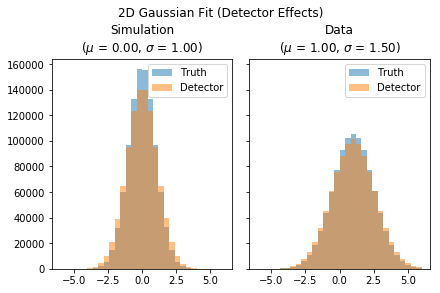

In [15]:
bins = np.linspace(-6, 6, 31)

fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('2D Gaussian Fit (Detector Effects)')

axs[0].set_title("Simulation\n($\mu$ = {:.2f}, $\sigma$ = {:.2f})".format(
    theta0_param[0], theta0_param[1]))
axs[0].hist(theta0_T, bins=bins, alpha=0.5, label='Truth')
axs[0].hist(theta0_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend()

axs[1].set_title("Data\n($\mu$ = {:.2f}, $\sigma$ = {:.2f})".format(
    theta1_param[0], theta1_param[1]))
axs[1].hist(theta1_T, bins=bins, alpha=0.5, label='Truth')
axs[1].hist(theta1_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend()

#fig.savefig("2D Gaussian: Data ($\mu$ = {:.2f}, $\sigma$ = {:.2f}) w detector effects.png".format(theta1_param[0], theta1_param[1]))
fig.show()

In [16]:
#'Erasing' Truth level for data, we can't actually observe this
theta1 = np.stack([np.zeros_like(theta0_D), theta0_D], axis=1)

In [17]:
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0_D, theta1_D])
y_true = np.concatenate([labels0, labels1])
# 'hiding' truth level for simulation in model output (used in reweighting)
truth_level = np.concatenate([theta0_T, theta1_T])
yvals = np.stack([y_true, truth_level], axis=1)

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)
X_train_theta, y_train_theta = shuffle(xvals, yvals)

## Fitting Model

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Loading Model

In [18]:
# load json and create model
'''
json_file = open('2d_gaussian_dctr_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dctr_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
dctr_model.load_weights("2d_gaussian_dctr_model.h5")
print("Loaded model from disk")
'''

'\njson_file = open(\'2d_gaussian_dctr_model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\ndctr_model = keras.models.model_from_json(loaded_model_json)\n# load weights into new model\ndctr_model.load_weights("2d_gaussian_dctr_model.h5")\nprint("Loaded model from disk")\n'

### Cross Section for $\mu$

In [19]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000


def my_loss_wrapper(val=0., reweight_analytically=False, MSE_loss=True):
    def my_loss(y_true, y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size))
        y_labels = tf.gather(y_true, [0], axis=1)  #actual y_true for loss
        x_T = tf.gather(y_true, [1], axis=1)  # sim truth for reweighting

        theta_prime = [val, theta1_param[1]]  # fixed theta_sigma = sigma_truth

        if reweight_analytically:
            # analytical reweight
            weights = analytical_reweight(events=x_T, param=theta_prime)
        else:
            # NN (DCTR) reweight
            weights = reweight(events=x_T, param=theta_prime)

        if MSE_loss:
            # Mean Squared Loss
            t_loss = y_labels * (y_labels - y_pred)**2 + weights * (
                1. - y_labels) * (y_labels - y_pred)**2
        else:
            # Categorical Cross-Entropy Loss
            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_labels) * K.log(y_pred) + weights *
                       (1 - y_labels) * K.log(1 - y_pred))
        return K.mean(t_loss)

    return my_loss


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [20]:
thetas = np.linspace(-2, 2, 17)
lvals = []
vlvals = []

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper(theta),
                  metrics=['accuracy'])
    model.fit(np.array(X_train),
              y_train,
              epochs=100,
              batch_size=1000,
              validation_data=(np.array(X_test), y_test),
              verbose=1,
              callbacks=[earlystopping])
    lvals += [np.min(model.history.history['loss'])]
    vlvals += [np.min(model.history.history['val_loss'])]
    print(lvals)
    print
    pass
print(lvals)

testing theta = : -2.0

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1228 - acc: 0.2903 - val_loss: 0.1219 - val_acc: 0.2893
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1219 - acc: 0.2896 - val_loss: 0.1219 - val_acc: 0.2898
Epoch 3/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1219 - acc: 0.2895 - val_loss: 0.1219 - val_acc: 0.2888
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1219 - acc: 0.2896 - val_loss: 0.1219 - val_acc: 0.2878
Epoch 5/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1219 - acc: 0.2896 - val_loss: 0.1219 - val_acc: 0.2907
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1219 - acc: 0.2896 - val_loss: 0.121

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2373 - acc: 0.3272 - val_loss: 0.2376 - val_acc: 0.3264
Epoch 11/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2373 - acc: 0.3272 - val_loss: 0.2376 - val_acc: 0.3261
Epoch 12/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2372 - acc: 0.3273 - val_loss: 0.2379 - val_acc: 0.3262
[0.12189492417871953, 0.13467893448472024, 0.14806123162806034, 0.1622769716978073, 0.17656221951544285, 0.1907737924903631, 0.20428884841501713, 0.21648369516432286, 0.22800474075973035, 0.23723593820631503]
testing theta = : 0.5
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2442 - acc: 0.3284 - val_loss: 0.2444 - val_acc: 0.3287
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2442 - acc: 0.3281 - val_loss: 0.2444 - val_acc: 0.3266
Epoch 3/100
1000000/

Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2458 - acc: 0.1791 - val_loss: 0.2367 - val_acc: 0.1749
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2381 - acc: 0.1771 - val_loss: 0.2373 - val_acc: 0.1741
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2371 - acc: 0.1766 - val_loss: 0.2372 - val_acc: 0.1735
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2372 - acc: 0.1762 - val_loss: 0.2372 - val_acc: 0.1771
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2373 - acc: 0.1764 - val_loss: 0.2372 - val_acc: 0.1768
Epoch 6/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2374 - acc: 0.1766 - val_loss: 0.2372 - val_acc: 0.1755
[0.12189492417871953, 0.13467893448472024, 0.14806123162806034, 0.1622769716978073, 0.17656221951544

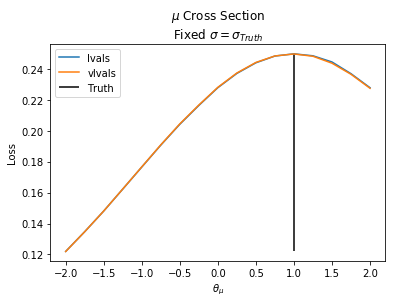

In [21]:
plt.plot(thetas, lvals, label='lvals')
plt.plot(thetas, vlvals, label='vlvals')
plt.title("$\mu$ Cross Section\nFixed $\sigma = \sigma_{Truth}$")
plt.xlabel(r'$\theta_{\mu}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[0],
           ymin=np.min(lvals),
           ymax=np.max(lvals),
           label='Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-DetectorEffects-\mu cross section.png")
plt.show()

### Cross Section for $\sigma$

In [22]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model = Model(inputs=myinputs, outputs=predictions)
model.summary()
batch_size = 1000


def my_loss_wrapper(val=0., reweight_analytically=False, MSE_loss=True):
    def my_loss(y_true, y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size))
        y_labels = tf.gather(y_true, [0], axis=1)  #actual y_true for loss
        x_T = tf.gather(y_true, [1], axis=1)  # sim truth for reweighting

        theta_prime = [theta1_param[0], val]  # fixed theta_sigma = sigma_truth

        if reweight_analytically:
            # analytical reweight
            weights = analytical_reweight(events=x_T, param=theta_prime)
        else:
            # NN (DCTR) reweight
            weights = reweight(events=x_T, param=theta_prime)

        if MSE_loss:
            # Mean Squared Loss
            t_loss = y_labels * (y_labels - y_pred)**2 + weights * (
                1. - y_labels) * (y_labels - y_pred)**2
        else:
            # Categorical Cross-Entropy Loss
            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_labels) * K.log(y_pred) + weights *
                       (1 - y_labels) * K.log(1 - y_pred))
        return K.mean(t_loss)

    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [23]:
thetas = np.linspace(0.5, 4.5, 17)
lvals = []
vlvals = []

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

for theta in thetas:
    print("testing theta = :", theta)
    model.compile(optimizer='adam',
                  loss=my_loss_wrapper(theta),
                  metrics=['accuracy'])
    model.fit(np.array(X_train),
              y_train,
              epochs=100,
              batch_size=batch_size,
              validation_data=(np.array(X_test), y_test),
              verbose=1,
              callbacks=[earlystopping])
    lvals += [np.min(model.history.history['loss'])]
    vlvals += [np.min(model.history.history['val_loss'])]
    print
    pass
print(lvals)

testing theta = : 0.5
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2015 - acc: 0.2491 - val_loss: 0.2000 - val_acc: 0.2482
Epoch 2/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1998 - acc: 0.2471 - val_loss: 0.2000 - val_acc: 0.2486
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1998 - acc: 0.2473 - val_loss: 0.2001 - val_acc: 0.2461
Epoch 4/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1998 - acc: 0.2472 - val_loss: 0.2007 - val_acc: 0.2421
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1997 - acc: 0.2471 - val_loss: 0.2002 - val_acc: 0.2487
Epoch 6/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.1998 - acc: 0.2470 - val_loss: 0.2001 - val_acc: 0.2490
testing theta = : 0.75
Train on 1000000 samples, validate on 1000000 samples
E

1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2057 - acc: 0.2488 - val_loss: 0.2041 - val_acc: 0.2386
Epoch 4/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2057 - acc: 0.2455 - val_loss: 0.2039 - val_acc: 0.2511
Epoch 5/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.2061 - acc: 0.2471 - val_loss: 0.2036 - val_acc: 0.2431
Epoch 6/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2056 - acc: 0.2470 - val_loss: 0.2038 - val_acc: 0.2498
testing theta = : 3.5
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/100
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2084 - acc: 0.2511 - val_loss: 0.1967 - val_acc: 0.2465
Epoch 2/100
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.1991 - acc: 0.2479 - val_loss: 0.1967 - val_acc: 0.2477
Epoch 3/100
1000000/1000000 [==============================] - 7s 7us/step - loss: 0.198

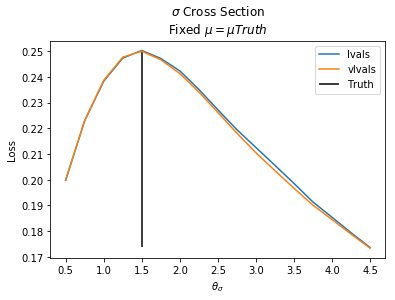

In [24]:
plt.plot(thetas, lvals, label='lvals')
plt.plot(thetas, vlvals, label='vlvals')
plt.title("$\sigma$ Cross Section\nFixed $\mu = \mu{Truth}$")
plt.xlabel(r'$\theta_{\sigma}$')
plt.ylabel('Loss')
plt.vlines(theta1_param[1],
           ymin=np.min(lvals),
           ymax=np.max(lvals),
           label='Truth')
plt.legend()
#plt.savefig("GaussianAltFit-2D-DetectorEffects-\sigma cross section.png")
plt.show()

We've shown for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$

Now, let's do the $\theta$ and $g$ optimization together with a minimax setup.

### Building and Training Fitting Model

In [25]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(
    ". theta fit = ", model_fit.layers[-1].get_weights()[-1]))
theta_fit_init = [0., 1.]

fit_vals = [theta_fit_init]
append_fit_value = LambdaCallback(
    on_epoch_end=lambda batch, logs: fit_vals.append(model_fit.layers[-1].
                                                     get_weights()[0]))

callbacks = [print_weights, append_fit_value]

earlystopping = EarlyStopping(patience=10, restore_best_weights=True)

In [26]:
myinputs_fit = Input(shape=(1, ))
x_fit = Dense(128, activation='relu')(myinputs_fit)
x2_fit = Dense(128, activation='relu')(x_fit)
predictions_fit = Dense(1, activation='sigmoid')(x2_fit)
identity = Lambda(lambda x: x + 0)(predictions_fit)

model_fit = Model(inputs=myinputs_fit, outputs=identity)
model_fit.layers[np.size(model_fit.layers) - 1].add_weight(
    name="thetaX",
    shape=(2, ),
    initializer=keras.initializers.Constant(value=theta_fit_init),
    trainable=True)
model_fit.summary()

batch_size = 2 * N
iterations = 50

# optimizer will be refined as fit progresses for better precision
lr_initial = 5e-1
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])


def my_loss_wrapper_fit(
        mysign=1,  # -1 for training theta, +1 for training g
        reweight_analytically=False,
        MSE_loss=True):
    theta = 0.  #starting value

    #Getting theta_prime:

    def my_loss(y_true, y_pred):

        # Getting theta_prime:
        if mysign == 1:
            # regular batch size
            y_true = tf.gather(y_true, np.arange(1000))
            # when not training theta, fetch as np array
            theta_prime = model_fit.layers[-1].get_weights()[0]
        else:
            # special theta batch size
            y_true = tf.gather(y_true, np.arange(batch_size))
            # when training theta, fetch as tf.Variable
            theta_prime = model_fit.trainable_weights[-1]

        y_labels = tf.gather(y_true, [0], axis=1)  #actual y_true for loss
        x_T = tf.gather(y_true, [1], axis=1)  # sim truth for reweighting

        if reweight_analytically:
            # analytical reweight
            weights = analytical_reweight(x_T, theta_prime)
        else:
            # NN reweight
            weights = reweight(x_T, theta_prime)

        if MSE_loss:
            # Mean Squared Loss
            t_loss = mysign * (y_labels * (y_labels - y_pred)**2 + weights *
                               (1. - y_labels) * (y_labels - y_pred)**2)
        else:
            # Categorical Cross-Entropy Loss
            #Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -mysign * ((y_labels) * K.log(y_pred) + weights *
                                (1 - y_labels) * K.log(1 - y_pred))

        return K.mean(t_loss)

    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 2         
Total params: 16,899
Trainable params: 16,899
Non-trainable params: 0
_________________________________________________________________


In [27]:
for iteration in range(iterations):
    print("Iteration: ", iteration)
    for i in range(len(model_fit.layers) - 1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    model_fit.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
                      loss=my_loss_wrapper_fit(1),
                      metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train),
                  y_train,
                  epochs=20,
                  batch_size=1000,
                  validation_data=(np.array(X_test), y_test),
                  verbose=1,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit(-1),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta),
                  y_train_theta,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=1,
                  callbacks=callbacks)

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):, 0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):, 1]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate(
        (argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu >= iteration - index_refine[-1] - 20]

    extrema_sigma = np.concatenate(
        (argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration -
                                  index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema_mu", extrema_mu)
    print("extrema_sigma", extrema_sigma)
    '''

    if (len(extrema_mu) == 0) or (
            len(extrema_sigma)
            == 0):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >=
                                     6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10

        mean_fit = np.array([[
            np.mean(fit_vals_mu[len(fit_vals_mu) - 4:len(fit_vals_mu)]),
            np.mean(fit_vals_sigma[len(fit_vals_sigma) -
                                   4:len(fit_vals_sigma)])
        ]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass
    pass

Iteration:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2174 - acc: 0.3248 - val_loss: 0.2139 - val_acc: 0.3287
Epoch 2/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2136 - acc: 0.3291 - val_loss: 0.2136 - val_acc: 0.3290
Epoch 3/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2135 - acc: 0.3292 - val_loss: 0.2135 - val_acc: 0.3292
Epoch 4/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2134 - acc: 0.3293 - val_loss: 0.2135 - val_acc: 0.3292
Epoch 5/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2134 - acc: 0.3292 - val_loss: 0.2134 - val_acc: 0.3291
Epoch 6/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2134 - acc: 0.3293 - val_loss: 0.2134 - val_acc: 0.3292
Epoch 7/20
1000000/1000000 [==============================] - 8s 8us/step - los

Epoch 9/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2496 - acc: 0.1846 - val_loss: 0.2492 - val_acc: 0.1801
Epoch 10/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2499 - acc: 0.1828 - val_loss: 0.2491 - val_acc: 0.1774
Epoch 11/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2498 - acc: 0.1828 - val_loss: 0.2499 - val_acc: 0.1725
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 9s 5us/step - loss: -0.2492 - acc: 0.1866
. theta fit =  [0.90074944 1.2576199 ]
Iteration:  4
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 12s 12us/step - loss: 0.2476 - acc: 0.2655 - val_loss: 0.2476 - val_acc: 0.2642
Epoch 2/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2473 - acc: 0.2679 - val_loss: 0.2477 - val_acc: 0.2727
Epoch 3/20
1000000/1000000 [==============================] 

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2497 - acc: 0.2514 - val_loss: 0.2494 - val_acc: 0.2208
Epoch 6/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2497 - acc: 0.2313 - val_loss: 0.2495 - val_acc: 0.2105
Epoch 7/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2494 - acc: 0.2285 - val_loss: 0.2491 - val_acc: 0.2493
Epoch 8/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2496 - acc: 0.2348 - val_loss: 0.2491 - val_acc: 0.2307
Epoch 9/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2497 - acc: 0.2388 - val_loss: 0.2494 - val_acc: 0.2075
Epoch 10/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2493 - acc: 0.2262 - val_loss: 0.2491 - val_acc: 0.2661
Epoch 11/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2496 - acc: 0.2352 - val_loss: 0.2491 - val_acc: 0.2431
Epoch 12/20
1000000/1000000 [

Epoch 12/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2504 - acc: 0.1844 - val_loss: 0.2499 - val_acc: 0.1854
Epoch 13/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2503 - acc: 0.1992 - val_loss: 0.2500 - val_acc: 0.1723
Epoch 14/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2502 - acc: 0.1850 - val_loss: 0.2500 - val_acc: 0.2164
Epoch 15/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2501 - acc: 0.1937 - val_loss: 0.2499 - val_acc: 0.1932
Epoch 16/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2502 - acc: 0.1928 - val_loss: 0.2499 - val_acc: 0.1924
Epoch 17/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2502 - acc: 0.1957 - val_loss: 0.2499 - val_acc: 0.1773
Epoch 18/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2502 - acc: 0.1857 - val_loss: 0.2499 - val_acc: 0.1794
Epoch 19/20
1

1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2503 - acc: 0.2122 - val_loss: 0.2501 - val_acc: 0.2171
Epoch 17/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2503 - acc: 0.2220 - val_loss: 0.2501 - val_acc: 0.2114
Epoch 18/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2503 - acc: 0.2173 - val_loss: 0.2501 - val_acc: 0.2030
Epoch 19/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2502 - acc: 0.2084 - val_loss: 0.2502 - val_acc: 0.2079
Epoch 20/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2505 - acc: 0.2153 - val_loss: 0.2501 - val_acc: 0.2053
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 12s 6us/step - loss: -0.2501 - acc: 0.2051
. theta fit =  [0.9889713 1.4478992]
Iteration:  24
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] -

. theta fit =  [1.0101898 1.4665805]
Iteration:  28
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 17s 17us/step - loss: 0.2505 - acc: 0.2183 - val_loss: 0.2500 - val_acc: 0.2133
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2505 - acc: 0.2217 - val_loss: 0.2501 - val_acc: 0.1899
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2505 - acc: 0.2184 - val_loss: 0.2501 - val_acc: 0.2131
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2502 - acc: 0.2223 - val_loss: 0.2501 - val_acc: 0.2421
Epoch 5/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2504 - acc: 0.2316 - val_loss: 0.2502 - val_acc: 0.2261
Epoch 6/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2502 - acc: 0.2232 - val_loss: 0.2502 - val_acc: 0.2547
Epoch 7/20
1000000/1000000 [===========

Epoch 11/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2502 - acc: 0.2312 - val_loss: 0.2502 - val_acc: 0.2130
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 13s 7us/step - loss: -0.2502 - acc: 0.2069
. theta fit =  [1.0101194 1.4723028]
Iteration:  32
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 18s 18us/step - loss: 0.2507 - acc: 0.2033 - val_loss: 0.2499 - val_acc: 0.2129
Epoch 2/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2508 - acc: 0.2088 - val_loss: 0.2500 - val_acc: 0.2127
Epoch 3/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2506 - acc: 0.2185 - val_loss: 0.2501 - val_acc: 0.2276
Epoch 4/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2505 - acc: 0.2239 - val_loss: 0.2500 - val_acc: 0.1990
Epoch 5/20
1000000/1000000 [=========================

Epoch 18/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2502 - acc: 0.2072 - val_loss: 0.2501 - val_acc: 0.2421
Epoch 19/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2503 - acc: 0.2115 - val_loss: 0.2500 - val_acc: 0.1995
Epoch 20/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2502 - acc: 0.2047 - val_loss: 0.2501 - val_acc: 0.1868
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.2501 - acc: 0.1866
. theta fit =  [1.0157869 1.4781609]
Iteration:  36
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 19s 19us/step - loss: 0.2511 - acc: 0.2068 - val_loss: 0.2498 - val_acc: 0.1876
Epoch 2/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2510 - acc: 0.1989 - val_loss: 0.2499 - val_acc: 0.1964
Epoch 3/20
1000000/1000000 [=======================

1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2504 - acc: 0.2145 - val_loss: 0.2501 - val_acc: 0.2007
Epoch 13/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2502 - acc: 0.1973 - val_loss: 0.2501 - val_acc: 0.1948
Epoch 14/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2501 - acc: 0.2006 - val_loss: 0.2501 - val_acc: 0.2127
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 15s 7us/step - loss: -0.2501 - acc: 0.2202
. theta fit =  [1.0181572 1.4821236]
Iteration:  44
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 20s 20us/step - loss: 0.2510 - acc: 0.2147 - val_loss: 0.2498 - val_acc: 0.1999
Epoch 2/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2509 - acc: 0.2140 - val_loss: 0.2499 - val_acc: 0.2398
Epoch 3/20
1000000/1000000 [==============================] - 1

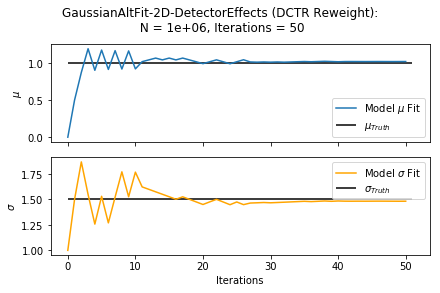

In [28]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "GaussianAltFit-2D-DetectorEffects (DCTR Reweight):\n N = {:.0e}, Iterations = {:.0f}"
    .format(N, iterations))
axs[0].plot(fit_vals[:, 0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(fit_vals[:, 1], label='Model $\sigma$ Fit', color='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-DetectorEffects (DCTR Reweight):\n N = {:.0e}, Iterations = {:.0f}.png"
#     .format(N, iterations))
plt.show()

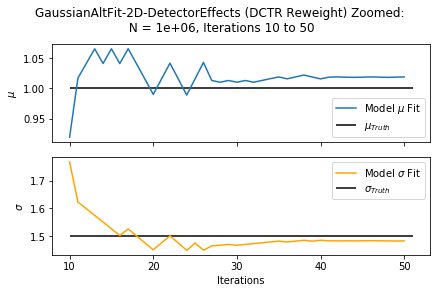

In [29]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "GaussianAltFit-2D-DetectorEffects (DCTR Reweight) Zoomed:\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:, 0])),
            fit_vals[index_refine[1]:, 0],
            label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0],
              index_refine[1],
              len(fit_vals),
              label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:, 1])),
            fit_vals[index_refine[1]:, 1],
            label='Model $\sigma$ Fit',
            color='orange')
axs[1].hlines(theta1_param[1],
              index_refine[1],
              len(fit_vals),
              label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-DetectorEffects (DCTR Reweight) Zoomed:\n N = {:.0e}, Iterations {:.0f} to {:.0f}.png"
#     .format(N, index_refine[1], iterations))
plt.show()

#### Compare Fitting between DCTR Reweighting and Analytical Reweighting

In [30]:
fit_vals = [theta_fit_init]
optimizer = keras.optimizers.Adam(lr=lr_initial)
index_refine = np.array([0])

In [31]:
for iteration in range(iterations):
    print("Iteration: ", iteration)
    for i in range(len(model_fit.layers) - 1):
        train_theta = False
        model_fit.layers[i].trainable = True
        pass

    model_fit.layers[-1].trainable = False
    #model.summary()

    model_fit.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
                      loss=my_loss_wrapper_fit(1, reweight_analytically=True),
                      metrics=['accuracy'])
    print("Training g")
    model_fit.fit(np.array(X_train),
                  y_train,
                  epochs=20,
                  batch_size=1000,
                  validation_data=(np.array(X_test), y_test),
                  verbose=1,
                  callbacks=[earlystopping])

    #Now, fix g and train \theta.

    for i in range(len(model_fit.layers) - 1):
        model_fit.layers[i].trainable = False
        pass

    model_fit.layers[-1].trainable = True
    model_fit.compile(optimizer=optimizer,
                      loss=my_loss_wrapper_fit(-1, reweight_analytically=True),
                      metrics=['accuracy'])
    #model.summary()
    print("Training theta")
    model_fit.fit(np.array(X_train_theta),
                  y_train_theta,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=1,
                  callbacks=callbacks)

    # Detecting oscillatory behavior (oscillations around truth values)
    # Then refine fit by decreasing learning rate /10

    fit_vals_mu = np.array(fit_vals)[(index_refine[-1]):, 0]
    fit_vals_sigma = np.array(fit_vals)[(index_refine[-1]):, 1]

    # Get RECENT relative extrema, if it alternates --> oscillatory behavior
    extrema_mu = np.concatenate(
        (argrelmin(fit_vals_mu)[0], argrelmax(fit_vals_mu)[0]))
    extrema_mu = extrema_mu[extrema_mu >= iteration - index_refine[-1] - 20]

    extrema_sigma = np.concatenate(
        (argrelmin(fit_vals_sigma)[0], argrelmax(fit_vals_sigma)[0]))
    extrema_sigma = extrema_sigma[extrema_sigma >= iteration -
                                  index_refine[-1] - 20]
    '''
    print("index_refine", index_refine)
    print("extrema_mu", extrema_mu)
    print("extrema_sigma", extrema_sigma)
    '''

    if (len(extrema_mu) == 0) or (
            len(extrema_sigma)
            == 0):  # If none are found, keep fitting (catching index error)
        pass
    elif (len(extrema_mu) >= 6) and (len(extrema_sigma) >=
                                     6):  #If enough are found, refine fit
        index_refine = np.append(index_refine, iteration + 1)
        print('==============================\n' +
              '====Refining Learning Rate====\n' +
              '==============================')
        optimizer.lr = optimizer.lr / 10

        mean_fit = np.array([[
            np.mean(fit_vals_mu[len(fit_vals_mu) - 4:len(fit_vals_mu)]),
            np.mean(fit_vals_sigma[len(fit_vals_sigma) -
                                   4:len(fit_vals_sigma)])
        ]])

        model_fit.layers[-1].set_weights(mean_fit)
    pass
    pass

Iteration:  0
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 20s 20us/step - loss: 0.2502 - acc: 0.2223 - val_loss: 0.2493 - val_acc: 0.2393
Epoch 2/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2497 - acc: 0.2042 - val_loss: 0.2488 - val_acc: 0.2498
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2494 - acc: 0.2425 - val_loss: 0.2489 - val_acc: 0.2527
Epoch 4/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2492 - acc: 0.2490 - val_loss: 0.2489 - val_acc: 0.2365
Epoch 5/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2490 - acc: 0.2259 - val_loss: 0.2489 - val_acc: 0.2498
Epoch 6/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2432 - val_loss: 0.2489 - val_acc: 0.2498
Epoch 7/20
1000000/1000000 [==============================] - 9s 9us/step

1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2864 - val_loss: 0.2491 - val_acc: 0.2479
Epoch 4/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2490 - acc: 0.2853 - val_loss: 0.2487 - val_acc: 0.2729
Epoch 5/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2487 - acc: 0.2901 - val_loss: 0.2487 - val_acc: 0.3058
Epoch 6/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2488 - acc: 0.2893 - val_loss: 0.2486 - val_acc: 0.2954
Epoch 7/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2487 - acc: 0.2877 - val_loss: 0.2486 - val_acc: 0.2949
Epoch 8/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2486 - acc: 0.2885 - val_loss: 0.2487 - val_acc: 0.3063
Epoch 9/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2487 - acc: 0.2856 - val_loss: 0.2486 - val_acc: 0.2943
Epoch 10/20
10000

Epoch 9/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.2827 - val_loss: 0.2489 - val_acc: 0.2828
Epoch 10/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2492 - acc: 0.2926 - val_loss: 0.2490 - val_acc: 0.2036
Epoch 11/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2488 - acc: 0.2683 - val_loss: 0.2489 - val_acc: 0.3241
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 14s 7us/step - loss: -0.2491 - acc: 0.3208
. theta fit =  [1.0113872 1.5240694]
Iteration:  13
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 21s 21us/step - loss: 0.2502 - acc: 0.2580 - val_loss: 0.2483 - val_acc: 0.2736
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2501 - acc: 0.2341 - val_loss: 0.2485 - val_acc: 0.2819
Epoch 3/20
1000000/1000000 [==============================] 

Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2493 - acc: 0.2540 - val_loss: 0.2490 - val_acc: 0.2498
Epoch 5/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2551 - val_loss: 0.2489 - val_acc: 0.2658
Epoch 6/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2535 - val_loss: 0.2490 - val_acc: 0.2498
Epoch 7/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2463 - val_loss: 0.2490 - val_acc: 0.2495
Epoch 8/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2409 - val_loss: 0.2490 - val_acc: 0.2848
Epoch 9/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.2568 - val_loss: 0.2490 - val_acc: 0.2498
Epoch 10/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2494 - acc: 0.2440 - val_loss: 0.2489 - val_acc: 0.2336
Epoch 11/20
1000000

Epoch 11/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.2339 - val_loss: 0.2489 - val_acc: 0.2498
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.2491 - acc: 0.1972
. theta fit =  [1.0197518 1.4967718]
Iteration:  22
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 23s 23us/step - loss: 0.2503 - acc: 0.2335 - val_loss: 0.2488 - val_acc: 0.2404
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.2287 - val_loss: 0.2486 - val_acc: 0.1933
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2498 - acc: 0.2224 - val_loss: 0.2488 - val_acc: 0.2499
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2494 - acc: 0.2386 - val_loss: 0.2488 - val_acc: 0.2662
Epoch 5/20
1000000/1000000 [==============================] -

Epoch 3/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2494 - acc: 0.2376 - val_loss: 0.2490 - val_acc: 0.2498
Epoch 4/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2490 - acc: 0.2361 - val_loss: 0.2490 - val_acc: 0.2537
Epoch 5/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2490 - acc: 0.2463 - val_loss: 0.2490 - val_acc: 0.2116
Epoch 6/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2380 - val_loss: 0.2490 - val_acc: 0.2498
Epoch 7/20
1000000/1000000 [==============================] - 10s 10us/step - loss: 0.2489 - acc: 0.2381 - val_loss: 0.2490 - val_acc: 0.2652
Epoch 8/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2489 - acc: 0.2317 - val_loss: 0.2490 - val_acc: 0.2498
Epoch 9/20
1000000/1000000 [==============================] - 11s 11us/step - loss: 0.2491 - acc: 0.2366 - val_loss: 0.2489 - val_acc: 0.2498
Epoch 

1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2490 - acc: 0.2450 - val_loss: 0.2490 - val_acc: 0.2498
Epoch 6/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2566 - val_loss: 0.2490 - val_acc: 0.2369
Epoch 7/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2489 - acc: 0.2474 - val_loss: 0.2490 - val_acc: 0.2681
Epoch 8/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.2434 - val_loss: 0.2490 - val_acc: 0.3118
Epoch 9/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2491 - acc: 0.2514 - val_loss: 0.2490 - val_acc: 0.2498
Epoch 10/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2494 - acc: 0.2639 - val_loss: 0.2490 - val_acc: 0.2418
Epoch 11/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2489 - acc: 0.2276 - val_loss: 0.2489 - val_acc: 0.3282
Training theta
Epoch 1/1
2000

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2492 - acc: 0.2344 - val_loss: 0.2491 - val_acc: 0.2537
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.2491 - acc: 0.2435
. theta fit =  [1.0048815 1.4886836]
Iteration:  40
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 22s 22us/step - loss: 0.2502 - acc: 0.2483 - val_loss: 0.2487 - val_acc: 0.2705
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2496 - acc: 0.2552 - val_loss: 0.2490 - val_acc: 0.2562
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2491 - acc: 0.2646 - val_loss: 0.2490 - val_acc: 0.2213
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.2555 - val_loss: 0.2490 - val_acc: 0.2703
Epoch 5/20
1000000/1000000 [==============================] - 9s 9us/step

1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.2545 - val_loss: 0.2491 - val_acc: 0.2659
Epoch 7/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2709 - val_loss: 0.2490 - val_acc: 0.3124
Epoch 8/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2491 - acc: 0.2652 - val_loss: 0.2490 - val_acc: 0.2294
Epoch 9/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.2458 - val_loss: 0.2490 - val_acc: 0.2704
Epoch 10/20
1000000/1000000 [==============================] - 8s 8us/step - loss: 0.2489 - acc: 0.2593 - val_loss: 0.2490 - val_acc: 0.2542
Epoch 11/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2491 - acc: 0.2678 - val_loss: 0.2490 - val_acc: 0.2498
Training theta
Epoch 1/1
2000000/2000000 [==============================] - 16s 8us/step - loss: -0.2492 - acc: 0.2041
. theta fit =  [1.0039002 1.487747 ]
Iteration:  4

. theta fit =  [1.0032098 1.4877332]
Iteration:  49
Training g
Train on 1000000 samples, validate on 1000000 samples
Epoch 1/20
1000000/1000000 [==============================] - 23s 23us/step - loss: 0.2504 - acc: 0.2505 - val_loss: 0.2485 - val_acc: 0.2498
Epoch 2/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2502 - acc: 0.2576 - val_loss: 0.2486 - val_acc: 0.2413
Epoch 3/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2500 - acc: 0.2477 - val_loss: 0.2488 - val_acc: 0.2642
Epoch 4/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2494 - acc: 0.2572 - val_loss: 0.2490 - val_acc: 0.3136
Epoch 5/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2490 - acc: 0.2660 - val_loss: 0.2490 - val_acc: 0.2700
Epoch 6/20
1000000/1000000 [==============================] - 9s 9us/step - loss: 0.2489 - acc: 0.2770 - val_loss: 0.2493 - val_acc: 0.2321
Epoch 7/20
1000000/1000000 [=============

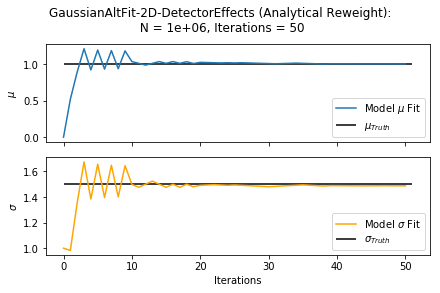

In [32]:
fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "GaussianAltFit-2D-DetectorEffects (Analytical Reweight):\n N = {:.0e}, Iterations = {:.0f}"
    .format(N, iterations))
axs[0].plot(fit_vals[:, 0], label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0], 0, len(fit_vals), label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(fit_vals[:, 1], label='Model $\sigma$ Fit', color='orange')
axs[1].hlines(theta1_param[1], 0, len(fit_vals), label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-DetectorEffects (Analytical Reweight):\n N = {:.0e}, Iterations = {:.0f}.png"
#     .format(N, iterations))
plt.show()

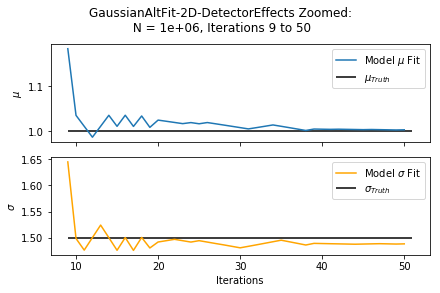

In [33]:
# Zoom into later iterations (finer fit)

fit_vals = np.array(fit_vals)
fig, axs = plt.subplots(2, sharex=True, constrained_layout=True)
fig.suptitle(
    "GaussianAltFit-2D-DetectorEffects Zoomed:\n N = {:.0e}, Iterations {:.0f} to {:.0f}"
    .format(N, index_refine[1], iterations))
axs[0].plot(np.arange(index_refine[1], len(fit_vals[:, 0])),
            fit_vals[index_refine[1]:, 0],
            label='Model $\mu$ Fit')
axs[0].hlines(theta1_param[0],
              index_refine[1],
              len(fit_vals),
              label='$\mu_{Truth}$')
axs[0].set_ylabel(r'$\mu$')
axs[0].legend()

axs[1].plot(np.arange(index_refine[1], len(fit_vals[:, 1])),
            fit_vals[index_refine[1]:, 1],
            label='Model $\sigma$ Fit',
            color='orange')
axs[1].hlines(theta1_param[1],
              index_refine[1],
              len(fit_vals),
              label='$\sigma_{Truth}$')
axs[1].set_ylabel(r'$\sigma$')
axs[1].legend()
plt.xlabel("Iterations")
# plt.savefig(
#     "GaussianAltFit-2D-DetectorEffects (Analytical Reweight) Zoomed:\n N = {:.0e}, Iterations {:.0f} to {:.0f}.png"
#     .format(N, index_refine[1], iterations))
plt.show()